# Metric learning

Одной из подобластей Representation learning является Metric learning.

Целью Metric learning является обучение модели, которая отображает данные в пространство представлений — **эмбеддингов** (embedding). При этом вводится требование: **расстояние между векторами в пространстве эмбеддингов должно отражать схожесть исходных объектов**, то есть схожие объекты должны отображаться в близкие вектора, а различающиеся — в далекие.

Metric learning может применяться в задачах, когда не представляется возможным разбить данные на классы так, чтобы в каждом классе было достаточно много объектов.

Рассмотрим, например, задачу распознавания лиц.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/videoanalytics.png" width="900"></center>

На вход системе подается фото лица человека. Требуется сопоставить его с другим изображением или изображениями, например, хранящимися в базе данных, и таким образом идентифицировать человека на фотографии.

На первый взгляд кажется, что это задача классификации.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/classifier_scheme.png" width="700"></center>

Все изображения одного человека будем считать относящимися к одному классу, и модель будет этот класс предсказывать.

Для небольшой организации, в которой всего несколько десятков сотрудников такой подход может сработать.
При этом возникнут проблемы:

1. Чтобы обучить такую ​​систему, нам сначала потребуется много (десятки) разных изображений каждого сотрудника.

2. Когда человек присоединяется к организации или покидает ее, приходится менять структуру модели и обучать ее заново.

Это практически невозможно для крупных организаций, где набор и увольнение происходят почти каждую неделю. И в принципе невозможно для города масштаба Москвы или Лондона, в котором миллионы жителей и сотни тысяч приезжих.

## Формирование векторов признаков

Поэтому используется другой подход.
Вместо того, чтобы классифицировать изображения, модель учится выделять ключевые признаки и на их основе строить компактный вектор, достаточно точно описывающий лицо.

Может возникнуть вопрос: не потеряем ли мы важную информацию, сжав изображение в несколько сотен чисел?

Чтобы ответить на него, вспомним, как работает [фоторобот 📚[wiki]](https://en.wikipedia.org/wiki/Facial_composite).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/photorobot.png" width="700"></center>

Для получения фотореалистичного изображения лица достаточно нескольких ключевых признаков: глаза, волосы, рот, нос...
Каждый из них кодируется максимум несколькими сотнями целочисленных значений.

Значит, вектора-признака, скажем, из 128 вещественных чисел будет более чем достаточно.
Правда, интерпретировать значения, которые закодирует в него нейросеть, будет не столь просто.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/face_as_embedding.png" width="500"></center>

В англоязычной литературе такой вектор признаков называется **эмбеддинг**, и мы тоже будем использовать это обозначение.

Если нам удастся обучить модель кодировать в эмбеддинг признаки, важные для сравнения, то мы сможем сравнивать векторы между собой в метрическом пространстве.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/face_dist.png" width="700"></center>




Если расстояние между векторами для лиц, которые похожи друг на друга, будут маленькими, а у непохожих, наоборот, большими, то мы сможем экспериментально подобрать порог $d$, и, сравнивая с ним расстояние между двумя векторами, принимать решение: принадлежат ли они одному человеку или нет.

*Можно оценивать не расстояние, а схожесть (similarity). В этом случае неравенства поменяют знак, но логика останется прежней*.

Теперь, чтобы идентифицировать человека, требуется только одно изображение его лица. Эмбеддинг  этого изображения можно сравнить с эмбеддингами других лиц из БД, используя  [k-NN 📚[wiki]](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) или иной метод кластеризации.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/search_in_embedding_space.jpg" width="700"></center>


Такая модель не учится классифицировать изображение напрямую по какому-либо из выходных классов. Она учится выделять признаки, важные при сравнении.

Такой подход решает обе проблемы, о которых мы говорили выше:
- для обучения такой сети нам не требуется много экземпляров объектов одного класса, а   достаточно лишь нескольких,
- простота обучения в случае появления новых объектов.

## Сиамская сеть

Какая архитектура должна быть у модели, генерирующей векторы признаков?

Можно было бы использовать обычную сеть, обученную для задачи классификации, и затем удалить из нее один или несколько последних слоёв.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/embedding_from_classifier.png" width="700"></center>

Активации последнего слоя представляют собой отклики на некие высокоуровневые признаки, потенциально важные для классификации, и их можно интерпретировать как эмбеддинг.

In [ ]:
import torch
from torchvision.models import alexnet


face1 = torch.randn((3, 224, 224))
face2 = torch.randn((3, 224, 224))

model = alexnet(weights="AlexNet_Weights.DEFAULT")
# remove classification layer
model.fc = model.classifier[6] = torch.nn.Identity()

# get embeddings
embedding1 = model(face1.unsqueeze(0))
embedding2 = model(face2.unsqueeze(0))

diff = torch.nn.functional.pairwise_distance(embedding1, embedding2)
print("L2 distance: ", diff.item())

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 43.0MB/s]


L2 distance:  30.6625919342041


Такой подход будет работать.
Однако можно заметно улучшить точность, используя функцию потерь, которая оценивает качество именно сравнения, а не классификации.

Рассмотрим подход, основанный на методологии, описанной в статье [Siamese Neural Networks for One-shot Image Recognition (Koch et al., 2015) 🎓[arxiv]](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/siamese_neural_network_scheme.png" width="800"></center>

Два входных изображения ($x_1$ и $x_2$) проходят через одну и ту же сверточную сеть, на выходе для каждого изображения генерируется вектор признаков фиксированной длины ($h_1$ и $h_2$ соответственно).

Модель обучается генерировать близкие вектора для изображений одной персоны и далекие для разных.

Оценивая расстояние между двумя векторами признаков,
которое будет малым для схожих объектов и большим для различных, мы сможем оценить их сходство. Это центральная идея сиамских сетей.

Исторически одной из первых функций потерь для сиамких сетей была Contrastive Loss, о ней подробнее можно прочитать в статье [Dimensionality Reduction by Learning an Invariant Mapping (Hadsell et al., 2005) 🎓[arxiv]](https://www.researchgate.net/publication/4246277_Dimensionality_Reduction_by_Learning_an_Invariant_Mapping).


В PyTorch есть реализация
[Cosine Embedding Loss 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html), она позволяет обучать модель на парах изображений, оптимизируя [косинусное расстояние 📚[wiki]](https://en.wikipedia.org/wiki/Cosine_similarity) между эмбеддингами.

$$\large
\begin{align}
\text{Cosine Embedding Loss}\ (x_1, x_2, y) = \left\{
\begin{array}{cl}
1 - \text{cos}(x_1, x_2), & \text{if} \ \ y = 1 \\
\text{max}(0, \text{cos}(x_1, x_2) - \text{margin}), & \text{if} \ \ y = -1
\end{array}
\right.
\end{align}$$

Здесь $\large x_1$ и $\large x_2$ — эмбеддинги пары изображений, а $\large y$ — метка данной пары, равная $\large 1$, если в паре два изображения одного человека, и $\large -1$, если разных.




### Triplet Loss

Следующей идеей является  Triplet loss, которой требуется три эмбеддинга вместо двух.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/triplet_loss_scheme.png" width="800"></center>

Чтобы сгенерировать три эмбеддинга, модель должна получить на вход три изображения.

Первые два должны относиться к одному и тому же объекту (человеку), а третье — к другому.

Таким образом, триплет состоит из опорного (якорного, anchor), положительного (positive) и отрицательного (negative) образцов.

[[arxiv] 🎓 FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832).

Сама функция потерь выглядит следующим образом:

$$\large \text{Triplet Loss} (a, p, n) = \text{max}\{0, \ \ d(a, p) - d(a, n) + \text{margin}\},$$

где:

$\large a$ — эмбеддинг опорного объекта,

$\large p$ — эмбеддинг положительного объекта,

$\large n$ — эмбеддинг отрицательного объекта,

$\large d(x, y) = ||x - y||_p$ — функция расстояния между эмбеддингами ($L_p$—норма),

$\large \text{margin}$ — это константа или минимальный "зазор", на который расстояние до эмбеддинга отрицательного объекта обязано превосходить расстояние до эмбеддинга положительного объекта.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/triplet_loss_idea_scheme.png" width="900"></center>



В ходе обучения с  Triplet Loss расстояние между эмбеддингами опорного и позитивного объектов уменьшается, а между эмбеддингами опорного и отрицательного — увеличивается.

Важным дополнением является то, что эмбеддинги нормируются. В результате нормировки каждый вектор признаков будет иметь единичную длину.

$$ \large \text{cosine_similarity} = \cos(\theta) = \dfrac{a \cdot b  }{|a||b|} $$

Если вектора имеют единичную длину, то косинус угла между ними равен скалярному произведению :

$$\large \text{cosine_similarity} = a \cdot b $$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/sphere_distance.png" width="400"></center>




Теперь мы можем рассматривать эмбеддинги как точки на $n$-мерной сфере с радиусом $1$.

Это удобно, так как все расстояния между ними будут лежать на отрезке $[0; 2]$, и нам будет проще подобрать порог для сравнения.

Кроме того, можно использовать другие меры расстояния, например, [косинусное расстояние 📚[wiki]](https://en.wikipedia.org/wiki/Cosine_similarity), которое определяется углом между векторами, лежит на отрезке $[-1; 1]$ и соответствует расстоянию между точками на поверхности сферы.

В PyTorch есть две реализации Triplet Loss.

[[doc] 🛠️](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html) `TripletMarginLoss` — минимизирует $L_p$ норму.

In [ ]:
from torch import nn

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)

loss = triplet_loss(anchor, positive, negative)
print(loss)

tensor(0.9142, grad_fn=<MeanBackward0>)


[[doc] 🛠️](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss) `TripletMarginWithDistanceLoss` — позволяет задать произвольную функцию расстояния через аргумент `distance_function`.

In [ ]:
import torch.nn.functional as F

triplet_loss = nn.TripletMarginWithDistanceLoss(
    margin=1.0, distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)
)
loss = triplet_loss(anchor, positive, negative)
print(loss)

tensor(0.9825, grad_fn=<MeanBackward0>)


## Реализация сиамской сети


### Загрузка данных

Загрузим небольшой фрагмент датасета [The Database of Faces (AT&T) 🛠️[doc]](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) с лицами. Внутри архива фото лиц сгруппированы по папкам:

```
faces/
├── training/
|   ├── s1/
|   |   ├── 1.pgm
|   |   ├ ...
|   |   └── 10.pgm
|   ├ ... (excluding 5...7)
|   └── s40/
|       ├── 1.pgm
|       ├ ...
|       └── 10.pgm
└── testing/
    ├── s5/
    |   ├── 1.pgm
    |   ├ ...
    |   └── 10.pgm
    ├ ...
    └── s7/
        ├── 1.pgm
        ├ ...
        └── 10.pgm

```


В каждой папке по 10 фото лица одного и того же человека.

In [ ]:
!pip install -q lightning

!wget -qN https://ml.gan4x4.ru/msu/datasets/small_face_dataset.zip

!unzip -qn small_face_dataset.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.7 MB/s eta 0:00:00


Чтобы результаты воспроизводились, зафиксируем случайные состояния.

In [ ]:
import torch
import random
import numpy as np
import lightning as L


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)
L.seed_everything(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

### Датасет для работы с Triplet Loss

Для Triplet Loss потребуются три изображения: anchor, positive, negative, и метод `__getitem__` должен возвращать их нам. Первые два должны принадлежать одному человеку, а третье — другому.



In [ ]:
from glob import glob
from PIL import Image
from torch.utils.data import Dataset


class SiameseNetworkDataset(Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        # list of paths to all images in self.dir
        self.files = glob(f"{self.dir}/**/*.pgm", recursive=True)
        self.person_index = self.build_index()

    def build_index(self):
        """
        Creates a dictionary "person_index" with such structure:
        {'s1': ['faces/training/s1/1.pgm', ..., 'faces/training/s1/10.pgm'],
         's2': ...}

        keys   — IDs of persons ('s1', 's2', ...)
        values — lists of paths to person's images
        """

        person_index = {}
        for path in self.files:
            id = self.path2id(path)
            if id not in person_index:
                person_index[id] = []
            person_index[id].append(path)
        return person_index

    def path2id(self, path):
        """
        Takes full path, for example 'faces/training/s1/1.pgm'
        and extracts ID from it, for example 's1'
        """

        return path.replace(self.dir, "").split("/")[0]

    def __getitem__(self, index):
        anchor_path = self.files[index]
        # given anchor path we need to find positive and negative examples
        positive_path = self.find_positive(anchor_path)
        negative_path = self.find_negative(anchor_path)

        # Loading the images
        anchor = Image.open(anchor_path)
        positive = Image.open(positive_path)
        negative = Image.open(negative_path)

        if self.transform is not None:  # Apply image transformations
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

    def find_positive(self, anchor_path):
        """
        Given an anchor_path this function:
        1) extracts person's ID from anchor_path
        2) returns path to random image of THIS person, excepting anchor
        """

        id = self.path2id(anchor_path)
        all_exept_my = self.person_index[id].copy()
        all_exept_my.remove(anchor_path)
        positive_path = random.choice(all_exept_my)
        return positive_path

    def find_negative(self, anchor_path):
        """
        Given an anchor_path this function:
        1) extracts person's ID from anchor_path
        2) returns path to random image of randomly selected ANOTHER person
        """

        id = self.path2id(anchor_path)
        all_exept_my_ids = list(self.person_index.keys())
        all_exept_my_ids.remove(id)
        selected_id = random.choice(all_exept_my_ids)
        negative_path = random.choice(self.person_index[selected_id])
        return negative_path

    def __len__(self):
        return len(self.files)

Загрузчики данных не отличаются от загрузчиков для обычной сети.

Добавим к обучающим данным аугментацию в виде случайного отражения по вертикали.

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Apply augmentations on train data
transforms_train = transforms.Compose(
    [
        transforms.Resize((105, 105)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

transforms_test = transforms.Compose(
    [transforms.Resize((105, 105)), transforms.ToTensor()]
)

train_dataset = SiameseNetworkDataset("faces/training/", transform=transforms_train)
test_dataset = SiameseNetworkDataset("faces/testing/", transform=transforms_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

Выведем несколько изображений, чтобы убедиться, что класс датасета функционирует должным образом.

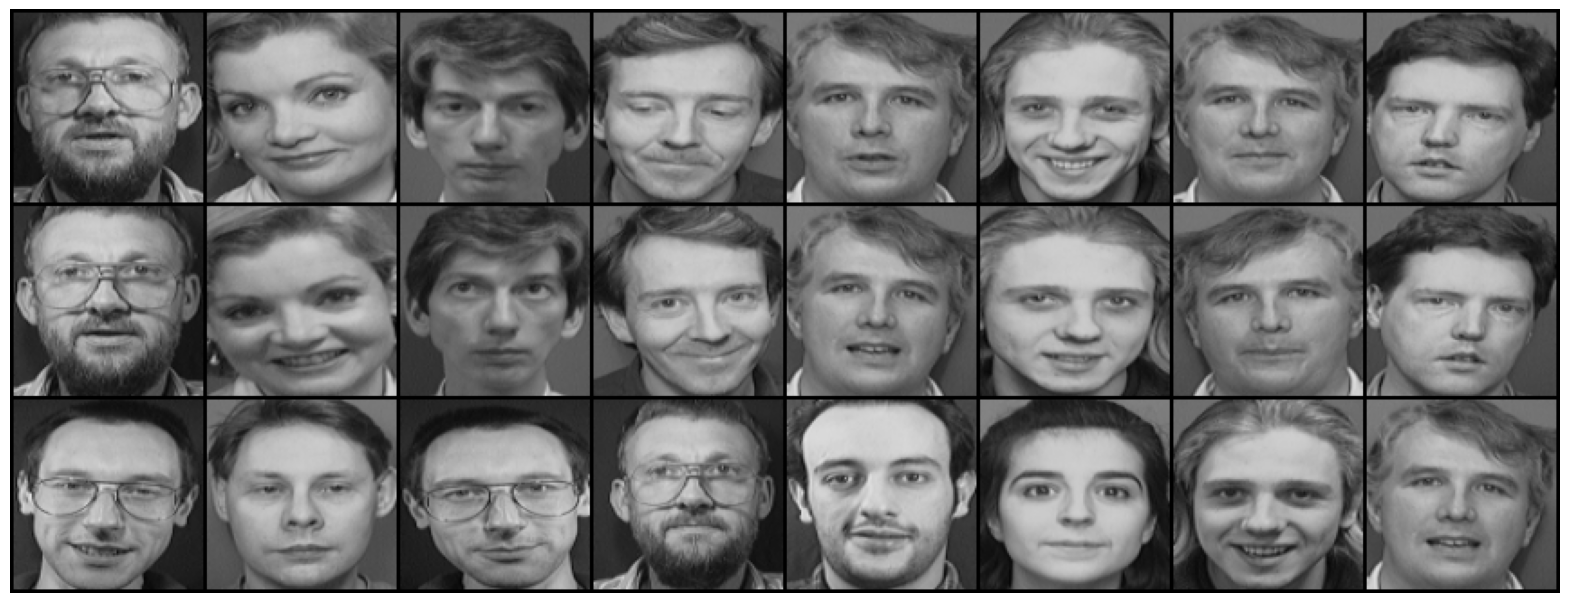

In [ ]:
import matplotlib.pyplot as plt


anchor, positive, negative = next(iter(train_loader))

# 8 - number of samples to visualise
anchor, positive, negative = anchor[:8], positive[:8], negative[:8]

# Show batch contents
concatenated = torch.cat((anchor, positive, negative), 0)
grid = torchvision.utils.make_grid(concatenated)

plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.gcf().set_size_inches(20, 60)
plt.show()

В каждом столбце тройка изображений. Первое и второе принадлежат одному человеку, третье — другому.

### Создание модели

Нас устроит любая модель для работы с изображениями. Например, ResNet-18.

Все, что от нас требуется, это:
- заменить последний слой,
- отправлять на анализ три изображения вместо одного. Соответственно, на выходе тоже будут три эмбеддинга.

Пожалуй, единственный вопрос — это размерность последнего слоя. В промышленных системах распознавания лиц, которые тренируются на датасетах из миллионов изображений, используются эмбеддинги размерностью от 128 до 512.

Для демонстрационной задачи нам должно хватить 32 значения. Количество выходов последнего линейного слоя установим равным 32.

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.3 MB/s eta 0:00:00


In [ ]:
import timm


class SiameseNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        # Replace ImageNet 1000 class classifier to linear layer with embedding_dim outputs
        self.model = timm.create_model(
            "resnet18.a1_in1k", num_classes=embedding_dim, pretrained=False
        )

        # Because we use grayscale images reduce input channel count to one
        # and reduce kernel_size to process images smaller than ImageNet
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )

    def forward(self, anchor, positive, negative):
        output_a = torch.nn.functional.normalize(self.model(anchor))
        output_p = torch.nn.functional.normalize(self.model(positive))
        output_n = torch.nn.functional.normalize(self.model(negative))

        return output_a, output_p, output_n

### Обучение

Отличие от  сетей для классификации в том, что у модели 3 выхода, и все их надо передать в функцию потерь. При этом нет меток в явном виде.
Определить, какой эмбеддинг относится к позитивному образцу, а какой — к негативному, можно только порядком их следования.

В качестве функции расстояния в Triplet Loss возьмем косинусное расстояние (величина, обратная к косинусной близости).

In [ ]:
class LitSiamese(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.criterion = nn.TripletMarginWithDistanceLoss(
            margin=1.0, distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)
        )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        anc, pos, neg = batch

        output_a, output_p, output_n = self.model(anc, pos, neg)
        loss = self.criterion(output_a, output_p, output_n)

        self.log("train_loss", loss)

        return loss

    def forward(self, anchor, positive, negative):
        return self.model(anchor, positive, negative)

Обучим модель.

In [ ]:
!mkdir lightning_logs
!mkdir lightning_logs/SiameseNetwork

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)

L.seed_everything(42)

embedding_dim = 32
model = LitSiamese(SiameseNet(embedding_dim))

logger = TensorBoardLogger(save_dir="lightning_logs", name="SiameseNetwork")
trainer = L.Trainer(max_epochs=20, logger=logger, log_every_n_steps=1)

trainer.fit(model, train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type                          | Params | Mode 
--------------------------------------------------------------------
0 | model     | SiameseNet                    | 11.2 M | train
1 | criterion | TripletMarginWithDistanceLoss | 0      | train
--------------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.736    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callback

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Проверка

Для начала выведем тройки изображений из проверочного датасета и посмотрим на косинусную близость (схожесть) для позитивных и негативных пар. Если модель обучилась, схожесть для позитивных пар будет больше, чем для негативных.

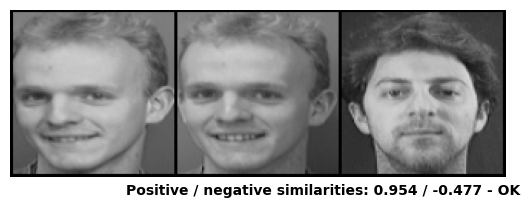

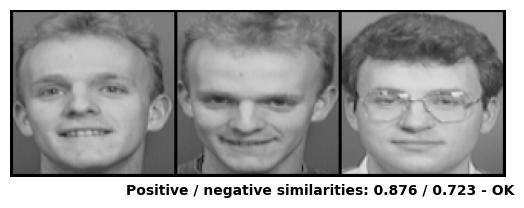

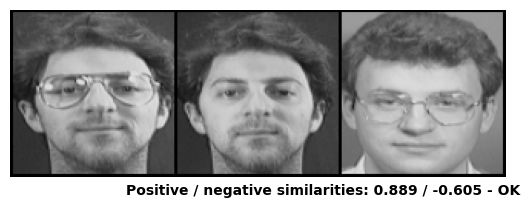

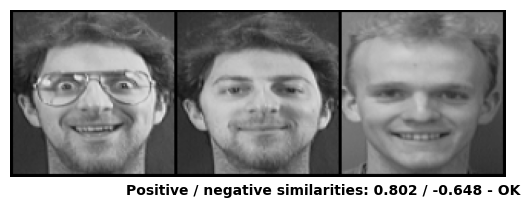

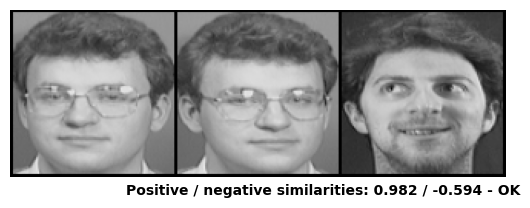

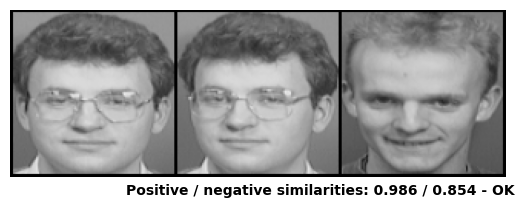

In [ ]:
# Helper method for visualization
def show(img, text=None):
    img_np = img.cpu().numpy()
    plt.axis("off")
    plt.text(75, 120, text, fontweight="bold")
    plt.imshow(np.transpose(img_np, (1, 2, 0)))  # [CxHxW] -> [HxWxC] for imshow
    plt.show()


def plot_imgs(model, test_loader):
    similarity_pos = []
    similarity_neg = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            anc, pos, neg = batch
            output_a, output_p, output_n = model(anc, pos, neg)

            # compute Cosine Similarity
            sim_pos = F.cosine_similarity(output_a, output_p).item()
            sim_neg = F.cosine_similarity(output_a, output_n).item()

            similarity_pos.append(sim_pos)
            similarity_neg.append(sim_neg)

            if not i % 5:
                concatenated = torch.cat((anc, pos, neg))
                result = "OK" if sim_neg < sim_pos else "BAD"
                show(
                    torchvision.utils.make_grid(concatenated),
                    f"Positive / negative similarities: {sim_pos:.3f} / {sim_neg:.3f} - {result}",
                )

    return similarity_pos, similarity_neg


set_random_seed(42)
similarity_pos, similarity_neg = plot_imgs(model, test_loader)

Но такая оценка субъективна. Давайте посмотрим на распределение схожестей по категориям:

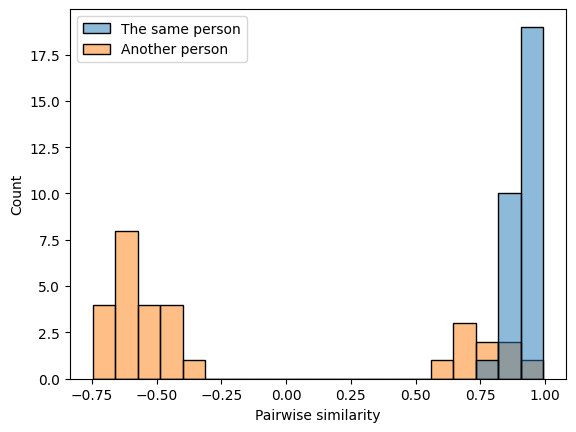

In [ ]:
import seaborn as sns

similarities = {"The same person": similarity_pos, "Another person": similarity_neg}

ax = sns.histplot(similarities, bins=20)
ax.set(xlabel="Pairwise similarity")
plt.show()

Видно, что схожесть между двумя фотографиями одного и того же человека в среднем больше, чем схожесть между фотографиями разных людей.

Если бы мы проектировали систему распознавания лиц, нужно было бы выбрать порог, чтобы сравнивать с ним схожесть и принимать решение о том, верифицировать фото как подлинное или нет.

Соответственно, для нашего игрушечного датасета такой порог следует выбрать $≈0.25$. При этом мы будем иметь малое количество ошибок первого и второго рода.

<font size = "5">Заключение по Mertric learning</font>

В случае, когда у нас не только мало данных, но еще и очень большое (возможно, неизвестное) число классов, можно воспользоваться подходом Metric learning. В этом случае нейронная сеть обучается не классифицировать объекты, а отображать их в пространство признаков — эмбеддингов. При этом абстрактная схожесть исходных объектов должна отражаться в метрической близости эмбеддингов.

[[git] 🐾 Репозиторий с разными реализациями функций потерь и майнеров](https://github.com/adambielski/siamese-triplet/tree/master)